# DINOv3 Dense Correspondence Pipeline

This notebook implements a complete pipeline for evaluating DINOv3 on the **SPair-71k** dense correspondence task, using Google Colab. The pipeline includes:

1. **Model Loading**: Automatic detection and loading of DINOv3 weights
2. **Feature Extraction**: Dense feature extraction from image pairs using vision transformer backbones
3. **Correspondence Matching**: Computing correspondences between image pairs through feature similarity
4. **Evaluation**: Computing PCK (Percentage of Correct Keypoints) metrics on the SPair-71k validation/test sets
5. **Optional Finetuning**: Light finetuning of the last transformer blocks on SPair-71k training data
6. **Optional Soft-Argmax**: Sub-pixel coordinate refinement using window-based soft-argmax

In [1]:
# ALL IMPORTS:
from google.colab import drive
import os, sys, shutil, importlib
import torch
import torch.nn.functional as F
import numpy as np
import requests
import zipfile
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import json
from torchvision import transforms
import requests
import tarfile
from tqdm import tqdm as tqdm_requests
import random
import subprocess
import timm
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Define Project and Data Roots (must be consistent with previous setup)
PROJECT_ROOT = '/content/AMLProject'
DATA_ROOT = '/content/drive/MyDrive/AMLProject/data'

# Create necessary directories if they don't exist
CHECKPOINT_DIR = os.path.join(PROJECT_ROOT, 'checkpoints')
OUTPUT_DIR = os.path.join(PROJECT_ROOT, 'outputs', 'dinov3') # Adjust for DINOv3 outputs
MODEL_DIR = os.path.join(PROJECT_ROOT, 'models')

for directory in [CHECKPOINT_DIR, OUTPUT_DIR, MODEL_DIR, DATA_ROOT]:
    os.makedirs(directory, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Data root: {DATA_ROOT}")
print(f"Output directory for DINOv3: {OUTPUT_DIR}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project root: /content/AMLProject
Data root: /content/drive/MyDrive/AMLProject/data
Output directory for DINOv3: /content/AMLProject/outputs/dinov3


In [3]:
# --- Configuring project path ---
PROJECT_ROOT = "/content/drive/MyDrive/AMLProject"
repo_path = os.path.join(PROJECT_ROOT, "SD4Match")

os.makedirs(PROJECT_ROOT, exist_ok=True)

# --- Downlaoding SD4Match if missing ---
if not os.path.exists(repo_path):
    print("📦 Downloading SD4Match repository from ActiveVisionLab...")

    zip_url = "https://github.com/ActiveVisionLab/SD4Match/archive/refs/heads/main.zip"
    zip_path = os.path.join(PROJECT_ROOT, "SD4Match.zip")

    # download

    r = requests.get(zip_url, stream=True)
    with open(zip_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

    # zip extraction

    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(PROJECT_ROOT)

    # move and rename
    extracted = os.path.join(PROJECT_ROOT, "SD4Match-main")
    if os.path.exists(repo_path):
        shutil.rmtree(repo_path)
    os.rename(extracted, repo_path)
    os.remove(zip_path)

    print("✓ Repository SD4Match ready at", repo_path)

if repo_path not in sys.path:
    sys.path.append(repo_path)

try:
    module = importlib.import_module("dataset.spair")
    SPairDataset = getattr(module, "SPairDataset")
    print("✓ SPairDataset imported successfully!")
except Exception as e:
    print("❌ Import Error:", e)


✓ SPairDataset imported successfully!


## Utility Functions

Window soft-argmax for sub-pixel refinement and finetuning utilities.

In [4]:
def window_soft_argmax(similarity, H, W, window=7, tau=0.05):
    """
    Window soft-argmax for sub-pixel coordinate prediction.

    Args:
        similarity: [N, H*W] or [N, H, W] similarity scores
        H, W: Grid dimensions
        window: Window size around peak (odd number)
        tau: Temperature for softmax (lower = sharper)

    Returns:
        [N, 2] tensor with (y, x) coordinates in patch space
    """
    if similarity.dim() == 2:
        N = similarity.size(0)
        sim2d = similarity.view(N, H, W)
    elif similarity.dim() == 3:
        N = similarity.size(0)
        sim2d = similarity
    else:
        raise ValueError("similarity must be [N,H*W] or [N,H,W]")

    r = window // 2
    preds = []

    for i in range(N):
        s = sim2d[i]  # [H, W]

        # Find peak with argmax
        idx = torch.argmax(s)
        y0 = (idx // W).item()
        x0 = (idx % W).item()

        # Extract window around peak
        y1, y2 = max(y0 - r, 0), min(y0 + r + 1, H)
        x1, x2 = max(x0 - r, 0), min(x0 + r + 1, W)

        sub = s[y1:y2, x1:x2]

        # Create coordinate grids
        yy, xx = torch.meshgrid(
            torch.arange(y1, y2, device=s.device, dtype=torch.float32),
            torch.arange(x1, x2, device=s.device, dtype=torch.float32),
            indexing='ij'
        )

        # Soft-argmax within window
        wts = torch.softmax(sub.flatten() / tau, dim=0).view_as(sub)
        y_hat = (wts * yy).sum()
        x_hat = (wts * xx).sum()

        preds.append(torch.stack([y_hat, x_hat]))

    return torch.stack(preds, dim=0)  # [N, 2]


def unfreeze_last_k_blocks(model, k, blocks_attr='blocks'):
    """
    Unfreeze the last k transformer blocks of a model.

    Args:
        model: The backbone model
        k: Number of last blocks to unfreeze
        blocks_attr: Attribute name for blocks (default 'blocks')

    Returns:
        List of trainable parameters
    """
    # Freeze all parameters
    for p in model.parameters():
        p.requires_grad = False

    # Unfreeze last k blocks
    blocks = getattr(model, blocks_attr)
    for block in blocks[-k:]:
        for p in block.parameters():
            p.requires_grad = True

    # Return trainable parameters
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    print(f"Unfroze last {k} blocks: {len(trainable_params)} trainable parameters")

    return trainable_params


def compute_keypoint_loss(sim2d, H, W, gt_xy_px, patch_size, use_soft=True, window=7, tau=0.05):
    """
    Compute loss from similarity map to ground truth keypoint.

    Args:
        sim2d: [H, W] similarity map
        H, W: Grid dimensions
        gt_xy_px: [2] ground truth coordinates in pixels (y, x)
        patch_size: Patch size for coordinate conversion
        use_soft: Use soft-argmax (True) or argmax (False)
        window, tau: Soft-argmax parameters

    Returns:
        Scalar loss
    """
    if use_soft:
        pred_xy_patch = window_soft_argmax(sim2d[None], H, W, window, tau)[0]
    else:
        idx = sim2d.argmax()
        pred_xy_patch = torch.stack([idx // W, idx % W]).float()

    pred_xy_px = (pred_xy_patch + 0.5) * patch_size

    return F.smooth_l1_loss(pred_xy_px, gt_xy_px)


print("✓ Utility functions loaded")

✓ Utility functions loaded


## SPair-71k Dataloader:
Complete dataloader for SPair-71k with keypoint annotations for finetuning.

In [5]:
class SPairDataset(Dataset):
    """SPair-71k dataset with keypoint annotations for correspondence learning."""

    def __init__(self, root_dir, split='trn', category=None, image_size=224, subset=None):
        self.root_dir = root_dir
        self.split = split
        self.category = category
        self.image_size = image_size

        self.pairs = self._load_pairs()
        if subset is not None:
            self.pairs = self.pairs[:subset]

        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        print(f"SPair-71k {split} dataset: {len(self.pairs)} pairs loaded")

    def _load_pairs(self):
        pairs = []
        # SPair-71k: JSON files are directly in PairAnnotation/{split}/ directory
        layout_dir = os.path.join(self.root_dir, 'PairAnnotation', self.split)

        if not os.path.exists(layout_dir):
            print(f"Warning: PairAnnotation directory not found: {layout_dir}")
            return pairs

        # Read all JSON files directly from the split directory
        for fname in os.listdir(layout_dir):
            if not fname.endswith('.json'):
                continue

            json_path = os.path.join(layout_dir, fname)
            try:
                with open(json_path, 'r') as f:
                    pair_data = json.load(f)

                cat = pair_data.get('category', 'unknown')

                # Filter by category if specified
                if self.category and cat != self.category:
                    continue

                pair = {
                    'category': cat,
                    'src_img': pair_data['src_imname'],
                    'tgt_img': pair_data['trg_imname'],
                    'src_kps': np.array(pair_data['src_kps']).reshape(-1, 2),
                    'tgt_kps': np.array(pair_data['trg_kps']).reshape(-1, 2),
                    'src_bbox': pair_data.get('src_bndbox', None),
                    'tgt_bbox': pair_data.get('trg_bndbox', None),
                }
                pairs.append(pair)

            except Exception as e:
                continue

        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]

        src_img_path = os.path.join(self.root_dir, 'JPEGImages',
                                    pair['category'], pair['src_img'])
        tgt_img_path = os.path.join(self.root_dir, 'JPEGImages',
                                    pair['category'], pair['tgt_img'])

        src_img_pil = Image.open(src_img_path).convert('RGB')
        tgt_img_pil = Image.open(tgt_img_path).convert('RGB')

        src_w, src_h = src_img_pil.size
        tgt_w, tgt_h = tgt_img_pil.size

        src_kps = pair['src_kps'].copy().astype(float)
        tgt_kps = pair['tgt_kps'].copy().astype(float)

        src_kps[:, 0] *= self.image_size / src_w
        src_kps[:, 1] *= self.image_size / src_h
        tgt_kps[:, 0] *= self.image_size / tgt_w
        tgt_kps[:, 1] *= self.image_size / tgt_h

        src_img = self.transform(src_img_pil)
        tgt_img = self.transform(tgt_img_pil)

        if pair['src_bbox'] is not None:
            src_bbox = np.array(pair['src_bbox'], dtype=float)
            src_bbox[0::2] *= self.image_size / src_w
            src_bbox[1::2] *= self.image_size / src_h
            src_bbox_wh = np.array([src_bbox[2] - src_bbox[0], src_bbox[3] - src_bbox[1]])
        else:
            src_bbox_wh = np.array([self.image_size, self.image_size])

        if pair['tgt_bbox'] is not None:
            tgt_bbox = np.array(pair['tgt_bbox'], dtype=float)
            tgt_bbox[0::2] *= self.image_size / tgt_w
            tgt_bbox[1::2] *= self.image_size / tgt_h
            tgt_bbox_wh = np.array([tgt_bbox[2] - tgt_bbox[0], tgt_bbox[3] - tgt_bbox[1]])
        else:
            tgt_bbox_wh = np.array([self.image_size, self.image_size])

        return {
            'src_img': src_img,
            'tgt_img': tgt_img,
            'src_kps': torch.from_numpy(src_kps).float(),
            'tgt_kps': torch.from_numpy(tgt_kps).float(),
            'src_bbox_wh': torch.from_numpy(src_bbox_wh).float(),
            'tgt_bbox_wh': torch.from_numpy(tgt_bbox_wh).float(),
            'category': pair['category'],
            'pair_id': idx
        }


def create_spair_dataloaders(root_dir, batch_size=1, num_workers=2,
                             train_subset=None, val_subset=None):
    train_dataset = SPairDataset(root_dir, split='trn', subset=train_subset)
    val_dataset = SPairDataset(root_dir, split='val', subset=val_subset)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                             num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                           num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader


print("✓ SPair-71k dataloader ready")

✓ SPair-71k dataloader ready


In [6]:
# Download SPair-71k dataset (if not already present)

data_path = os.path.join(DATA_ROOT, 'SPair-71k')

if not os.path.exists(data_path):
    print("Downloading SPair-71k dataset...")
    url = "http://cvlab.postech.ac.kr/research/SPair-71k/data/SPair-71k.tar.gz"
    tar_path = os.path.join(DATA_ROOT, 'SPair-71k.tar.gz')

    # Download with progress bar
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))

    with open(tar_path, 'wb') as f, tqdm_requests(
        desc='Downloading',
        total=total_size,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as pbar:
        for data in response.iter_content(chunk_size=1024):
            size = f.write(data)
            pbar.update(size)

    print("\nExtracting...")
    with tarfile.open(tar_path, 'r:gz') as tar:
        tar.extractall(DATA_ROOT)

    # Cleanup
    os.remove(tar_path)
    print("✓ Extraction complete")
else:
    print(f"✓ SPair-71k dataset already exists at {data_path}")

✓ SPair-71k dataset already exists at /content/drive/MyDrive/AMLProject/data/SPair-71k


## Configuration Flags

Set these flags to control the pipeline behavior:
- `ENABLE_FINETUNING`: Enable light finetuning of last transformer blocks
- `USE_SOFT_ARGMAX`: Use window soft-argmax instead of argmax for prediction

In [7]:
# ========== CONFIGURATION FLAGS ==========
# Set these flags to control behavior
ENABLE_FINETUNING = False  # Set True to enable light finetuning of last layers
USE_SOFT_ARGMAX = False    # Set True to use window soft-argmax instead of argmax

# Finetuning hyperparameters (only used if ENABLE_FINETUNING=True)
FINETUNE_K_LAYERS = 2      # Number of last transformer blocks to unfreeze {1, 2, 4}
FINETUNE_LR = 1e-5         # Learning rate
FINETUNE_WD = 1e-4         # Weight decay
FINETUNE_EPOCHS = 3        # Number of training epochs
FINETUNE_BATCH_SIZE = 1    # Batch size for training
FINETUNE_TRAIN_SUBSET = None  # None for full training set, or int for subset

# Soft-argmax hyperparameters (only used if USE_SOFT_ARGMAX=True)
SOFT_WINDOW = 7            # Window size around peak (odd number: 5, 7, 9)
SOFT_TAU = 0.05            # Softmax temperature (lower = sharper)

print(f"Configuration:")
print(f"  ENABLE_FINETUNING = {ENABLE_FINETUNING}")
print(f"  USE_SOFT_ARGMAX = {USE_SOFT_ARGMAX}")
if ENABLE_FINETUNING:
    print(f"  Finetuning: k={FINETUNE_K_LAYERS}, lr={FINETUNE_LR}, epochs={FINETUNE_EPOCHS}")
if USE_SOFT_ARGMAX:
    print(f"  Soft-argmax: window={SOFT_WINDOW}, tau={SOFT_TAU}")

Configuration:
  ENABLE_FINETUNING = False
  USE_SOFT_ARGMAX = False


In [8]:
# Extract and Normalize Common Utility Functions

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    print(f"Seed set to {seed}")

def detect_env():
    try:
        import google.colab
        return 'colab'
    except Exception:
        return 'local'

ENV = detect_env()
print('Environment:', ENV)

def get_paths():
    if ENV == 'colab':
        from google.colab import drive
        drive.mount('/content/drive')
        root = '/content/drive/MyDrive/AMLProject'
        data_root = os.path.join(root, 'data')
        model_root = os.path.join(root, 'models')
        out_root = os.path.join(root, 'outputs')
    else:
        root = os.getcwd()
        data_root = os.path.join(root, 'data')
        model_root = os.path.join(root, 'models')
        out_root = os.path.join(root, 'outputs')
    os.makedirs(data_root, exist_ok=True)
    os.makedirs(model_root, exist_ok=True)
    os.makedirs(out_root, exist_ok=True)
    return root, data_root, model_root, out_root

PROJECT_ROOT, DATA_ROOT, MODEL_ROOT, OUTPUT_ROOT = get_paths()
print('PROJECT_ROOT:', PROJECT_ROOT)
print('DATA_ROOT:', DATA_ROOT)
print('MODEL_ROOT:', MODEL_ROOT)
print('OUTPUT_ROOT:', OUTPUT_ROOT)
set_seed(42)

Environment: colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PROJECT_ROOT: /content/drive/MyDrive/AMLProject
DATA_ROOT: /content/drive/MyDrive/AMLProject/data
MODEL_ROOT: /content/drive/MyDrive/AMLProject/models
OUTPUT_ROOT: /content/drive/MyDrive/AMLProject/outputs
Seed set to 42


In [9]:
# Clone DINOv3 repository if it doesn't exist

# Assuming PROJECT_ROOT is defined from previous cells, e.g., /content/drive/MyDrive/AMLProject
dinov3_repo_path = os.path.join(PROJECT_ROOT, 'dinov3') # Or os.path.join(MODEL_ROOT, 'dinov3')

if not os.path.exists(dinov3_repo_path):
    print(f"📦 Cloning DINOv3 repository to {dinov3_repo_path}...")
    # Make sure the parent directory exists
    os.makedirs(dinov3_repo_path, exist_ok=True)
    # Use a subprocess to clone, as !git clone might not work reliably with paths containing spaces
    try:
        subprocess.run(['git', 'clone', 'https://github.com/facebookresearch/dinov3.git', dinov3_repo_path], check=True)
        print("✓ Repository DINOv3 cloned successfully!")
    except subprocess.CalledProcessError as e:
        print(f"❌ Error cloning DINOv3 repository: {e}")
        print("Please check your internet connection or the repository URL.")
else:
    print(f"✓ Repository DINOv3 already exists at {dinov3_repo_path}")

# Add the cloned repo to sys.path if not already there
if dinov3_repo_path not in sys.path:
    sys.path.insert(0, dinov3_repo_path)
    print(f"Added {dinov3_repo_path} to sys.path")


✓ Repository DINOv3 already exists at /content/drive/MyDrive/AMLProject/dinov3
Added /content/drive/MyDrive/AMLProject/dinov3 to sys.path


In [10]:
# Model: Auto-detect weights, fallback, and mock outputs

# Fallback paths if previous cell not run
if 'PROJECT_ROOT' not in globals() or 'MODEL_ROOT' not in globals():
    PROJECT_ROOT = os.getcwd()
    MODEL_ROOT = os.path.join(PROJECT_ROOT, 'models')
    OUTPUT_ROOT = os.path.join(PROJECT_ROOT, 'outputs')
    os.makedirs(MODEL_ROOT, exist_ok=True)
    os.makedirs(OUTPUT_ROOT, exist_ok=True)
    print('Initialized default paths (previous cell not run).')

# Device detection (CUDA, MPS, CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print('Device:', device)

# Auto-detect official DINOv3 repo and weights
def find_dinov3_repo_and_weights():
    candidates_repo = [
        Path(MODEL_ROOT) / 'dinov3',
        Path(PROJECT_ROOT) / 'models' / 'dinov3',
        Path(PROJECT_ROOT) / 'dinov3'
    ]
    repo_path = next((str(p) for p in candidates_repo if p.exists()), None)
    if repo_path and repo_path not in sys.path:
        sys.path.append(repo_path)

    candidates_weights = [
        Path(MODEL_ROOT) / 'dinov3_vitb16.pth',
        Path(MODEL_ROOT) / 'dinov3' / 'dinov3_vitb16.pth',
        Path(PROJECT_ROOT) / 'models' / 'dinov3_vitb16.pth',
        Path(PROJECT_ROOT) / 'models' / 'dinov3' / 'dinov3_vitb16.pth',
        Path(PROJECT_ROOT) / 'checkpoints' / 'dinov3' / 'dinov3_vitb16.pth',
        Path(PROJECT_ROOT) / 'weights' / 'dinov3_vitb16.pth'
    ]
    weight_path = next((str(p) for p in candidates_weights if p.exists()), None)
    return repo_path, weight_path

# Re-initialize dinov3_model and model_type before searching to clear previous state
dinov3_model = None
model_type = None

repo_path, weight_path = find_dinov3_repo_and_weights()
print('DINOv3 repo:', repo_path)
print('DINOv3 weight:', weight_path)

# Try official DINOv3 if both repo and weights are present
try:
    if repo_path:
        # Ensure the dinov3 library can be imported
        try:
            from dinov3.models.vision_transformer import vit_base
        except ImportError:
            print(f"Warning: DINOv3 repository found at {repo_path} but module 'dinov3.models.vision_transformer' could not be imported. Please ensure the repository is correctly set up.")
            vit_base = None

        if vit_base:
            dinov3_model = vit_base(patch_size=16)
            if weight_path:
                ckpt = torch.load(weight_path, map_location='cpu')
                missing, unexpected = dinov3_model.load_state_dict(ckpt, strict=False)
                print(f'Loaded DINOv3 weights. Missing={len(missing)} Unexpected={len(unexpected)}')
                model_type = 'DINOv3 ViT-B/16 (official)'
            else:
                print('Weights not found; using mock outputs with uninitialized model.')
                model_type = 'DINOv3 ViT-B/16 (no weights, mock)'
            dinov3_model.to(device).eval()
    if not dinov3_model:
        raise Exception('Official DINOv3 model or weights not found/loadable.')
except Exception as e:
    print('❌ ERROR: Official DINOv3 model could not be loaded.')
    print(f'   Details: {e}')
    print('\n📋 Required setup:')
    print('   1. Clone DINOv3 repository to models/dinov3/')
    print('   2. Download DINOv3 weights (dinov3_vitb16.pth) to models/ or checkpoints/')
    print('\nExiting - DINOv3 is required for this notebook.')
    raise RuntimeError('DINOv3 model not available. Please follow the setup instructions above.')

print('✓ Model type:', model_type)

def _model_image_size(model):
    cfg = getattr(model, 'default_cfg', {})
    size = cfg.get('input_size', (3, 224, 224))
    if isinstance(size, (list, tuple)) and len(size) == 3:
        return size[1]
    return 224

def _model_patch_size(model):
    ps = getattr(getattr(model, 'patch_embed', None), 'patch_size', (14, 14))
    if isinstance(ps, (list, tuple)) and len(ps) >= 1:
        return ps[0]
    return 14

# Unified feature extractor with optional mock when weights missing
class UnifiedFeatureExtractor:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.image_size = _model_image_size(model)
        self.patch_size = _model_patch_size(model)
        self.feat_dim = getattr(getattr(model, 'num_features', None), 'real', None) or getattr(model, 'num_features', 768)
        import torchvision.transforms as transforms
        from PIL import Image
        self.Image = Image
        self.transforms = transforms.Compose([
            transforms.Resize(self.image_size, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop(self.image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        # Corrected logic for use_mock: activate mock if the model itself is None
        self.use_mock = (self.model is None) or (model_type is not None and 'mock' in model_type)

    def preprocess(self, img):
        if isinstance(img, torch.Tensor): # Check if input is already a Tensor
            # Assume it's already preprocessed by the dataset (normalized, resized, ToTensor)
            # Just ensure it has a batch dimension and is on the correct device
            if img.dim() == 3: # (C, H, W)
                x = img.unsqueeze(0).to(self.device)
            elif img.dim() == 4: # (B, C, H, W)
                x = img.to(self.device)
            else:
                raise ValueError(f"Unexpected tensor dimension for image input: {img.dim()}")
            return x # Return directly if it's already a Tensor
        elif isinstance(img, self.Image.Image):
            pil = img
        else: # Assume numpy array if not PIL or Tensor
            pil = self.Image.fromarray(img)
        return self.transforms(pil).unsqueeze(0).to(self.device)

    @torch.no_grad()
    def extract(self, img, normalize=True):
        x = self.preprocess(img)
        if self.use_mock:
            grid = (self.image_size // self.patch_size)
            torch.manual_seed(42)
            feats = torch.randn(1, grid, grid, self.feat_dim)
        else:
            out = self.model.forward_features(x)
            if isinstance(out, dict) and 'x_norm_patchtokens' in out:
                tokens = out['x_norm_patchtokens']
            elif isinstance(out, dict) and 'x_norm_clstoken' in out and 'x_norm_patchtokens' in out:
                tokens = out['x_norm_patchtokens']
            else:
                tokens = out[:, 1:, :] if out.dim() == 3 else out
            grid = int(tokens.shape[1] ** 0.5)
            feats = tokens.view(1, grid, grid, self.feat_dim)
        if normalize:
            feats = F.normalize(feats, p=2, dim=-1)
        info = {
            'feature_size': (feats.shape[2], feats.shape[1]),
            'processed_size': (self.image_size, self.image_size),
            'patch_size': self.patch_size,
            'feat_dim': self.feat_dim
        }
        return feats.cpu(), info

feature_extractor = UnifiedFeatureExtractor(dinov3_model, device)
print('Feature extractor ready. Mock mode:', feature_extractor.use_mock, 'image_size:', feature_extractor.image_size, 'patch:', feature_extractor.patch_size)


Device: cuda
DINOv3 repo: /content/drive/MyDrive/AMLProject/dinov3
DINOv3 weight: /content/drive/MyDrive/AMLProject/models/dinov3_vitb16.pth
Loaded DINOv3 weights. Missing=0 Unexpected=37
✓ Model type: DINOv3 ViT-B/16 (official)
Feature extractor ready. Mock mode: False image_size: 224 patch: 16


In [11]:
if ENABLE_FINETUNING:
    print("=" * 60)
    print("LIGHT FINETUNING ENABLED")
    print("=" * 60)

    # Check if we have real model (not mock)
    if dinov3_model is None or feature_extractor.use_mock:
        print("\n⚠️  Cannot finetune: model is in mock mode or not loaded")
        print("   Please ensure DINOv3 weights are available")
    else:
        # Path to SPair-71k
        SPAIR_ROOT = os.path.join(DATA_ROOT if 'DATA_ROOT' in globals() else os.path.join(PROJECT_ROOT, 'data'), 'SPair-71k')

        if not os.path.exists(SPAIR_ROOT):
            print(f"\n⚠️  SPair-71k not found at: {SPAIR_ROOT}")
            print("   Download from: http://cvlab.postech.ac.kr/research/SPair-71k/")
        else:
            print(f"\nLoading SPair-71k from: {SPAIR_ROOT}")
            train_loader, val_loader = create_spair_dataloaders(
                SPAIR_ROOT,
                batch_size=FINETUNE_BATCH_SIZE,
                num_workers=2,
                train_subset=FINETUNE_TRAIN_SUBSET,
                val_subset=500
            )

            # Unfreeze last k blocks
            trainable_params = unfreeze_last_k_blocks(dinov3_model, FINETUNE_K_LAYERS, blocks_attr='blocks')

            # Setup optimizer
            optimizer = torch.optim.AdamW(trainable_params, lr=FINETUNE_LR, weight_decay=FINETUNE_WD)

            print(f"\nFinetuning configuration:")
            print(f"  Model: {model_type}")
            print(f"  k={FINETUNE_K_LAYERS} layers")
            print(f"  lr={FINETUNE_LR}, wd={FINETUNE_WD}")
            print(f"  epochs={FINETUNE_EPOCHS}")
            print(f"  train samples: {len(train_loader.dataset)}")
            print(f"  val samples: {len(val_loader.dataset)}")

            patch_size = feature_extractor.patch_size  # 14 or 16

            # Training
            dinov3_model.train()
            best_val_loss = float('inf')

            for epoch in range(FINETUNE_EPOCHS):
                epoch_loss = 0.0
                num_batches = 0

                for batch_idx, batch in enumerate(train_loader):
                    src_img = batch['src_img'].to(device)
                    tgt_img = batch['tgt_img'].to(device)
                    src_kps = batch['src_kps'].to(device)
                    tgt_kps = batch['tgt_kps'].to(device)

                    # Extract features
                    src_out = dinov3_model.get_intermediate_layers(src_img, n=1, return_class_token=False)[0]
                    tgt_out = dinov3_model.get_intermediate_layers(tgt_img, n=1, return_class_token=False)[0]

                    B = src_img.size(0)
                    num_patches = src_out.size(1)
                    grid_size = int(np.sqrt(num_patches))

                    batch_loss = 0.0
                    num_kps = 0

                    for b in range(B):
                        src_f = F.normalize(src_out[b], dim=-1)
                        tgt_f = F.normalize(tgt_out[b], dim=-1)

                        for kp_idx in range(src_kps[b].size(0)):
                            src_x = int(src_kps[b][kp_idx, 0].item() / patch_size)
                            src_y = int(src_kps[b][kp_idx, 1].item() / patch_size)
                            src_x = max(0, min(grid_size - 1, src_x))
                            src_y = max(0, min(grid_size - 1, src_y))

                            src_patch_idx = src_y * grid_size + src_x
                            sim = torch.matmul(tgt_f, src_f[src_patch_idx])
                            sim_2d = sim.view(grid_size, grid_size)

                            gt_xy = tgt_kps[b][kp_idx]
                            gt_yx = torch.stack([gt_xy[1], gt_xy[0]])

                            loss = compute_keypoint_loss(
                                sim_2d, grid_size, grid_size, gt_yx, patch_size,
                                use_soft=True, window=SOFT_WINDOW, tau=SOFT_TAU
                            )
                            batch_loss += loss
                            num_kps += 1

                    if num_kps > 0:
                        batch_loss = batch_loss / num_kps
                        optimizer.zero_grad()
                        batch_loss.backward()
                        optimizer.step()

                        epoch_loss += batch_loss.item()
                        num_batches += 1

                    if (batch_idx + 1) % 50 == 0:
                        print(f"  Epoch {epoch+1}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {epoch_loss/max(1,num_batches):.4f}")

                avg_train_loss = epoch_loss / max(1, num_batches)

                # Validation
                dinov3_model.eval()
                val_loss = 0.0
                val_batches = 0

                with torch.no_grad():
                    for batch in val_loader:
                        src_img = batch['src_img'].to(device)
                        tgt_img = batch['tgt_img'].to(device)
                        src_kps = batch['src_kps'].to(device)
                        tgt_kps = batch['tgt_kps'].to(device)

                        src_out = dinov3_model.get_intermediate_layers(src_img, n=1, return_class_token=False)[0]
                        tgt_out = dinov3_model.get_intermediate_layers(tgt_img, n=1, return_class_token=False)[0]

                        num_patches = src_out.size(1)
                        grid_size = int(np.sqrt(num_patches))

                        batch_val_loss = 0.0
                        num_kps = 0

                        for b in range(src_img.size(0)):
                            src_f = F.normalize(src_out[b], dim=-1)
                            tgt_f = F.normalize(tgt_out[b], dim=-1)

                            for kp_idx in range(src_kps[b].size(0)):
                                src_x = int(src_kps[b][kp_idx, 0].item() / patch_size)
                                src_y = int(src_kps[b][kp_idx, 1].item() / patch_size)
                                src_x = max(0, min(grid_size - 1, src_x))
                                src_y = max(0, min(grid_size - 1, src_y))

                                src_patch_idx = src_y * grid_size + src_x
                                sim = torch.matmul(tgt_f, src_f[src_patch_idx])
                                sim_2d = sim.view(grid_size, grid_size)

                                gt_xy = tgt_kps[b][kp_idx]
                                gt_yx = torch.stack([gt_xy[1], gt_xy[0]])

                                loss = compute_keypoint_loss(
                                    sim_2d, grid_size, grid_size, gt_yx, patch_size,
                                    use_soft=True, window=SOFT_WINDOW, tau=SOFT_TAU
                                )
                                batch_val_loss += loss
                                num_kps += 1

                        if num_kps > 0:
                            val_loss += (batch_val_loss / num_kps).item()
                            val_batches += 1

                avg_val_loss = val_loss / max(1, val_batches)

                print(f"\nEpoch {epoch+1}/{FINETUNE_EPOCHS}:")
                print(f"  Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

                # Save best
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    ckpt_path = os.path.join(OUTPUT_ROOT, f'dinov3_finetuned_k{FINETUNE_K_LAYERS}_best.pth')
                    torch.save({
                        'model_state_dict': dinov3_model.state_dict(),
                        'config': {'k': FINETUNE_K_LAYERS, 'lr': FINETUNE_LR}
                    }, ckpt_path)
                    print(f"  ✓ Best model saved")

                dinov3_model.train()

            dinov3_model.eval()
            print(f"\n✅ Finetuning completed! Best val loss: {best_val_loss:.4f}")

else:
    print("Finetuning disabled. Using pretrained weights only.")

Finetuning disabled. Using pretrained weights only.


## Light Finetuning (Optional)

If `ENABLE_FINETUNING=True`, this section finetunes the last k transformer blocks on SPair-71k with keypoint supervision.

In [12]:
# 4) Correspondence matching, PCK, and visualization (works with mock)

class CorrespondenceMatcher:
    def __init__(self, mutual_nn=False, use_soft_argmax=False, soft_window=7, soft_tau=0.05):
        self.mutual_nn = mutual_nn
        self.use_soft_argmax = use_soft_argmax
        self.soft_window = soft_window
        self.soft_tau = soft_tau

    def match(self, src_feats, tgt_feats):
        H, W, D = tgt_feats.shape[1], tgt_feats.shape[2], tgt_feats.shape[3]
        src_flat = src_feats.view(-1, D)
        tgt_flat = tgt_feats.view(-1, D)

        if self.use_soft_argmax:
            # Compute similarity on device
            sim = torch.matmul(src_flat, tgt_flat.T)  # [N, H*W]

            # Use window soft-argmax
            pred_coords = window_soft_argmax(
                sim, H, W,
                window=self.soft_window,
                tau=self.soft_tau
            )  # [N, 2] in (y, x) patch coordinates

            x = pred_coords[:, 1].cpu().numpy()
            y = pred_coords[:, 0].cpu().numpy()
        else:
            # Original argmax approach
            sim = src_flat.numpy() @ tgt_flat.numpy().T
            best = np.argmax(sim, axis=1)
            y = best // W
            x = best % W

        return np.stack([x, y], axis=1)

def pck(pred_kps, gt_kps, alpha=0.1, img_wh=(224,224)):
    if len(pred_kps)==0 or len(gt_kps)==0:
        return 0.0
    d = np.linalg.norm(pred_kps - gt_kps, axis=1)
    norm = np.sqrt(img_wh[0]**2 + img_wh[1]**2)
    thr = alpha*norm
    return float((d<=thr).mean())

def visualize(src_img, tgt_img, src_kps, pred_kps):
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(src_img)
    ax[0].scatter(src_kps[:,0], src_kps[:,1], c='r', s=40)
    ax[0].set_title('Source')
    ax[0].axis('off')
    ax[1].imshow(tgt_img)
    ax[1].scatter(pred_kps[:,0], pred_kps[:,1], c='b', s=40)
    ax[1].set_title('Target (Pred)')
    ax[1].axis('off')
    plt.tight_layout()
    return fig
print(f'Matcher (soft-argmax={'enabled' if USE_SOFT_ARGMAX else 'disabled'}), PCK, and visualization ready.')

Matcher (soft-argmax=disabled), PCK, and visualization ready.


PCK@0.1: 0.2500 (mock data)


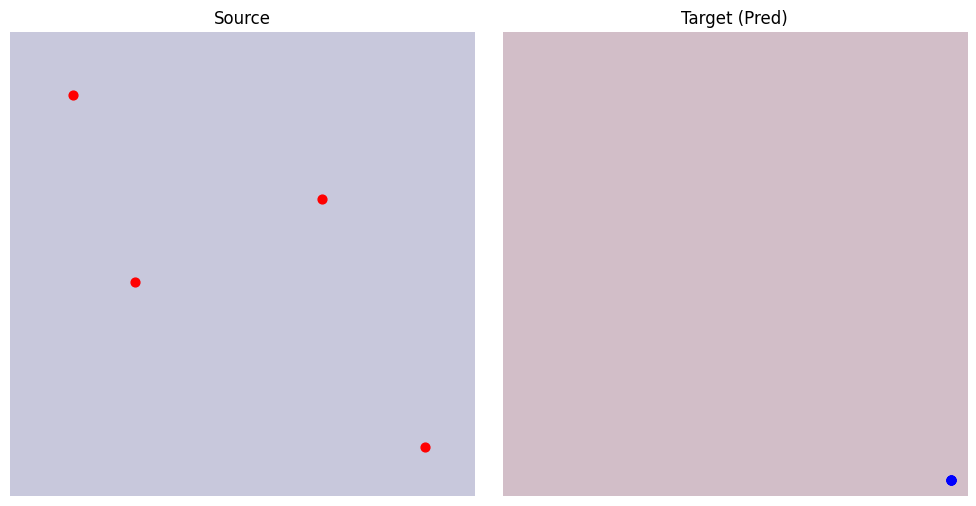

✓ End-to-end sanity check completed.


In [13]:
# 5) End-to-end sanity check with mock data

# Create synthetic images and keypoints
src = Image.new('RGB', (224,224), color=(200,200,220))
tgt = Image.new('RGB', (224,224), color=(210,190,200))
src_kps = np.array([[30,30],[60,120],[150,80],[200,200]], dtype=float)
gt_kps  = np.array([[40,40],[70,130],[160,90],[210,210]], dtype=float)  # fake GT

# Extract features (mock if weights missing)
src_feats, _ = feature_extractor.extract(src)  # (1,H,W,D)
tgt_feats, _ = feature_extractor.extract(tgt)
src_feats = src_feats[0]
tgt_feats = tgt_feats[0]
H, W, D = src_feats.shape

# Map keypoints to feature grid
patch = feature_extractor.patch_size
def kps_to_feat(kps):
    k = kps.copy()
    k[:,0] = np.clip(np.round(k[:,0] / patch), 0, W-1)
    k[:,1] = np.clip(np.round(k[:,1] / patch), 0, H-1)
    return k.astype(int)

src_feat_idx = kps_to_feat(src_kps)
tgt_feat_idx_gt = kps_to_feat(gt_kps)

# Gather source descriptors at keypoints
src_desc = src_feats[src_feat_idx[:,1], src_feat_idx[:,0], :]  # (K,D)

# Match only for keypoints with configuration
matcher = CorrespondenceMatcher(
    mutual_nn=False,
    use_soft_argmax=USE_SOFT_ARGMAX,
    soft_window=SOFT_WINDOW if USE_SOFT_ARGMAX else 7,
    soft_tau=SOFT_TAU if USE_SOFT_ARGMAX else 0.05
)
pred_feat_coords = matcher.match(src_desc[None, None, ...], tgt_feats[None, ...])
pred_feat_coords = pred_feat_coords[:len(src_kps)]  # (K,2)

# Map feature coords back to image pixels (center of patch)
pred_kps = np.stack([pred_feat_coords[:,0]*patch + patch//2,
                      pred_feat_coords[:,1]*patch + patch//2], axis=1).astype(float)

# Compute PCK
alpha_val = 0.1
pck_val = pck(pred_kps, gt_kps, alpha=alpha_val, img_wh=(224,224))
print(f'PCK@{alpha_val}: {pck_val:.4f} (mock data)')

# Visualize
fig = visualize(np.array(src), np.array(tgt), src_kps, pred_kps)
plt.show()
print('✓ End-to-end sanity check completed.')

In [14]:
# Helper function to denormalize images for visualization
def denorm_show(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor * std + mean
    img = torch.clamp(img, 0, 1)
    return img.permute(1, 2, 0).cpu().numpy()


class PCKEvaluator:
    """Evaluator for PCK metrics at different alpha thresholds."""

    def __init__(self, alphas=[0.05, 0.10, 0.15]):
        self.alphas = alphas

    def compute_pck(self, pred_kps, gt_kps, alpha, img_size=224):
        """Compute PCK for given alpha threshold."""
        distances = np.linalg.norm(pred_kps - gt_kps, axis=1)
        # Compute normalization factor (same as DINOv2)
        norm_factor = np.sqrt(img_size**2 + img_size**2)

        # Normalize distances (same as DINOv2)
        normalized_distances = distances / (norm_factor + 1e-8)

        # Compare with alpha threshold
        threshold = alpha
        return (normalized_distances <= threshold).astype(float), normalized_distances

    def evaluate_dataset(self, all_predictions, all_ground_truths):
        """Evaluate PCK across entire dataset."""
        all_correct = {alpha: [] for alpha in self.alphas}
        all_distances = []

        for pred_kps, gt_kps in zip(all_predictions, all_ground_truths):
            for alpha in self.alphas:
                correct, distances = self.compute_pck(pred_kps, gt_kps, alpha)
                all_correct[alpha].extend(correct)
                if alpha == self.alphas[0]:  # Solo una volta
                    all_distances.extend(distances)

        # Compute average PCK for each alpha
        avg_pck = {f'PCK@{alpha}': np.mean(all_correct[alpha])
                   for alpha in self.alphas}

        per_sample_pck = {f'PCK@{alpha}': all_correct[alpha]
                          for alpha in self.alphas}

        return avg_pck, per_sample_pck, np.array(all_distances)


def evaluate_on_dataset(dataset, feature_extractor, matcher, evaluator,
                       max_samples=None, save_visualizations=False):
    """
    Evaluate correspondence on entire dataset.

    Args:
        dataset: SPairDataset instance
        feature_extractor: UnifiedFeatureExtractor instance
        matcher: CorrespondenceMatcher instance
        evaluator: PCKEvaluator instance
        max_samples: Maximum samples to evaluate (None = all)
        save_visualizations: Whether to save sample visualizations

    Returns:
        results: Dictionary with evaluation metrics
    """
    print(f"Evaluating on {len(dataset)} samples...")

    all_predictions = []
    all_ground_truths = []
    all_confidences = []

    num_samples = min(max_samples, len(dataset)) if max_samples else len(dataset)

    for idx in tqdm(range(num_samples), desc="Evaluating"):
        sample = dataset[idx]

        src_img = sample['src_img']
        tgt_img = sample['tgt_img']
        src_kps = sample['src_kps']
        tgt_kps = sample['tgt_kps']

        # Get valid keypoints
        valid_mask = (src_kps[:, 0] >= 0) & (src_kps[:, 1] >= 0)
        valid_src_kps = src_kps[valid_mask]
        valid_tgt_kps = tgt_kps[valid_mask]

        if len(valid_src_kps) == 0:
            continue

        # Extract features usando il feature extractor
        src_feats, _ = feature_extractor.extract(src_img)
        tgt_feats, _ = feature_extractor.extract(tgt_img)

        # Remove batch dimension
        src_feats = src_feats[0]  # (H, W, D)
        tgt_feats = tgt_feats[0]  # (H, W, D)

        H, W, D = tgt_feats.shape
        patch_size = feature_extractor.patch_size

        # Map keypoints to feature grid
        def kps_to_feat(kps):
            k = kps.cpu().numpy() if isinstance(kps, torch.Tensor) else kps.copy()
            k[:, 0] = np.clip(np.round(k[:, 0] / patch_size), 0, W - 1)
            k[:, 1] = np.clip(np.round(k[:, 1] / patch_size), 0, H - 1)
            return k.astype(int)

        src_feat_idx = kps_to_feat(valid_src_kps)

        # Gather source descriptors at keypoints
        src_desc = src_feats[src_feat_idx[:, 1], src_feat_idx[:, 0], :]  # (K, D)

        # Match
        pred_feat_coords = matcher.match(src_desc[None, None, ...], tgt_feats[None, ...])
        pred_feat_coords = pred_feat_coords[:len(valid_src_kps)]  # (K, 2)

        # Map feature coords back to image pixels (center of patch)
        pred_kps = np.stack([
            pred_feat_coords[:, 0] * patch_size + patch_size // 2,
            pred_feat_coords[:, 1] * patch_size + patch_size // 2
        ], axis=1).astype(float)

        # Compute confidence scores based on similarity
        src_flat = src_desc.view(-1, D).cpu()
        tgt_flat = tgt_feats.view(-1, D).cpu()
        sim = torch.matmul(src_flat, tgt_flat.T)
        confidences = sim.max(dim=1)[0].numpy()  # Max similarity per ogni keypoint

        all_predictions.append(pred_kps)

        # Convert valid_tgt_kps to numpy array before appending
        if isinstance(valid_tgt_kps, torch.Tensor):
            all_ground_truths.append(valid_tgt_kps.cpu().numpy())
        else:
            all_ground_truths.append(valid_tgt_kps)

        all_confidences.append(confidences)

        # Save visualization for first few samples
        if save_visualizations and idx < 5:
            fig, axes = plt.subplots(1, 2, figsize=(14, 7))

            axes[0].imshow(denorm_show(src_img))
            valid_src_kps_np = valid_src_kps.cpu().numpy() if isinstance(valid_src_kps, torch.Tensor) else valid_src_kps
            axes[0].scatter(valid_src_kps_np[:, 0], valid_src_kps_np[:, 1],
                           c='red', s=100, marker='x', linewidths=3)
            axes[0].set_title(f'Source (Sample {idx})', fontsize=12, fontweight='bold')
            axes[0].axis('off')

            axes[1].imshow(denorm_show(tgt_img))
            valid_tgt_kps_np = valid_tgt_kps.cpu().numpy() if isinstance(valid_tgt_kps, torch.Tensor) else valid_tgt_kps
            axes[1].scatter(valid_tgt_kps_np[:, 0], valid_tgt_kps_np[:, 1],
                           c='lime', s=100, marker='o', alpha=0.6, linewidths=2,
                           edgecolors='darkgreen', label='GT')
            axes[1].scatter(pred_kps[:, 0], pred_kps[:, 1],
                           c='red', s=80, marker='x', linewidths=2, label='Pred')
            axes[1].set_title(f'Target (Sample {idx})', fontsize=12, fontweight='bold')
            axes[1].axis('off')
            axes[1].legend()

            plt.tight_layout()
            plt.savefig(os.path.join(OUTPUT_ROOT, f'match_sample_{idx}.png'),
                       dpi=150, bbox_inches='tight')
            plt.close()

    # Evaluate
    print("\nComputing PCK metrics...")
    avg_pck, per_sample_pck, all_distances = evaluator.evaluate_dataset(
        all_predictions, all_ground_truths
    )

    # Compute additional statistics
    all_confidences_flat = np.concatenate(all_confidences)

    results = {
        'avg_pck': avg_pck,
        'num_samples': num_samples,
        'num_keypoints': len(all_distances),
        'avg_confidence': float(all_confidences_flat.mean()),
        'distance_stats': {
            'mean': float(all_distances.mean()),
            'std': float(all_distances.std()),
            'median': float(np.median(all_distances)),
            'min': float(all_distances.min()),
            'max': float(all_distances.max())
        }
    }

    return results


## EVALUATION ON 50 SAMPLES

In [16]:
# Create evaluator
evaluator = PCKEvaluator(alphas=[0.05, 0.10, 0.15])

# Create dataset
print("Wait, loading pairs (takes some minutes)...")
SPAIR_ROOT = os.path.join(DATA_ROOT, 'SPair-71k')
dataset = SPairDataset(SPAIR_ROOT, split='test', subset=50)

# Create matcher
matcher = CorrespondenceMatcher(
    mutual_nn=False,
    use_soft_argmax=USE_SOFT_ARGMAX,
    soft_window=SOFT_WINDOW,
    soft_tau=SOFT_TAU
)

# Run evaluation on small subset
print("Running evaluation on 50 samples...")
results = evaluate_on_dataset(
    dataset=dataset,
    feature_extractor=feature_extractor,
    matcher=matcher,
    evaluator=evaluator,
    max_samples=50,
    save_visualizations=True
)

print("\n" + "="*60)
print("EVALUATION RESULTS (50 samples)")
print("="*60)
print(f"\nPCK Metrics:")
for key, value in results['avg_pck'].items():
    print(f"  {key}: {value:.4f} ({value*100:.2f}%)")

print(f"\nDataset Statistics:")
print(f"  Samples evaluated: {results['num_samples']}")
print(f"  Total keypoints: {results['num_keypoints']}")
print(f"  Average confidence: {results['avg_confidence']:.4f}")

print(f"\nDistance Statistics:")
for key, value in results['distance_stats'].items():
    print(f"  {key}: {value:.4f}")

# Save results
results_path = os.path.join(OUTPUT_ROOT, 'evaluation_results_subset.json')
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)
print(f"\n✓ Results saved to {results_path}")

Wait, loading pairs...
SPair-71k test dataset: 50 pairs loaded
Running evaluation on 50 samples...
Evaluating on 50 samples...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]


Computing PCK metrics...

EVALUATION RESULTS (50 samples)

PCK Metrics:
  PCK@0.05: 0.0272 (2.72%)
  PCK@0.1: 0.0845 (8.45%)
  PCK@0.15: 0.1553 (15.53%)

Dataset Statistics:
  Samples evaluated: 50
  Total keypoints: 367
  Average confidence: 0.9756

Distance Statistics:
  mean: 0.3264
  std: 0.1612
  median: 0.3292
  min: 0.0061
  max: 0.8162

✓ Results saved to /content/drive/MyDrive/AMLProject/outputs/evaluation_results_subset.json


##EVALUATION ON 600 SAMPLES

In [ ]:
# 🚀 EVALUATION: Evaluation on 600 pairs
print("="*70)
print("🔥 RUNNING EVALUATION ON 600 VALIDATION PAIRS")
print("="*70)

# Create evaluator
evaluator = PCKEvaluator(alphas=[0.05, 0.10, 0.15])

# Create dataset with 600 pairs
print("Wait, loading pairs (takes some minutes)...")
SPAIR_ROOT = os.path.join(DATA_ROOT, 'SPair-71k')
eval_dataset = SPairDataset(SPAIR_ROOT, split='test', subset=600)

print(f"\n📊 Dataset size: {len(eval_dataset)} pairs")
print(f"⏱️  Estimated time: ~{len(eval_dataset)*0.5/60:.1f} minutes\n")

# Create matcher
matcher = CorrespondenceMatcher(
    mutual_nn=False,
    use_soft_argmax=USE_SOFT_ARGMAX,
    soft_window=SOFT_WINDOW,
    soft_tau=SOFT_TAU
)

# Run evaluation
print("Starting evaluation...")
results = evaluate_on_dataset(
    dataset=eval_dataset,
    feature_extractor=feature_extractor,
    matcher=matcher,
    evaluator=evaluator,
    max_samples=None,  # All samples from subset
    save_visualizations=True  # Save first 5 visualizations
)

# Display results
print("\n" + "="*70)
print("📈 EVALUATION RESULTS (600 pairs)")
print("="*70)

print(f"\n🎯 PCK Metrics:")
for key, value in results['avg_pck'].items():
    print(f"   {key}: {value:.4f} ({value*100:.2f}%)")

print(f"\n📊 Dataset Statistics:")
print(f"   Samples evaluated: {results['num_samples']}")
print(f"   Total keypoints: {results['num_keypoints']}")
print(f"   Average confidence: {results['avg_confidence']:.4f}")

print(f"\n📏 Distance Statistics (pixels):")
for key, value in results['distance_stats'].items():
    print(f"   {key}: {value:.2f}")

# Save results
results_path = os.path.join(OUTPUT_ROOT, 'evaluation_results_600.json')
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n💾 Results saved to: {results_path}")
print("="*70)

🔥 RUNNING EVALUATION ON 600 VALIDATION PAIRS
SPair-71k val dataset: 600 pairs loaded

📊 Dataset size: 600 pairs
⏱️  Estimated time: ~5.0 minutes

Starting evaluation...
Evaluating on 600 samples...


Evaluating:   0%|          | 0/600 [00:00<?, ?it/s]


Computing PCK metrics...

📈 EVALUATION RESULTS (600 pairs)

🎯 PCK Metrics:
   PCK@0.05: 0.0311 (3.11%)
   PCK@0.1: 0.1045 (10.45%)
   PCK@0.15: 0.1925 (19.25%)

📊 Dataset Statistics:
   Samples evaluated: 600
   Total keypoints: 5438
   Average confidence: 0.9761

📏 Distance Statistics (pixels):
   mean: 0.31
   std: 0.16
   median: 0.30
   min: 0.00
   max: 0.81

💾 Results saved to: /content/drive/MyDrive/AMLProject/outputs/evaluation_results_600.json


##EVALUATION ON WHOLE DATASET

In [ ]:
# 🚀 FULL EVALUATION: Evaluation on whole dataset
print("="*70)
print("🔥 RUNNING FULL EVALUATION ON ENTIRE VALIDATION SET")
print("="*70)

# Create evaluator
evaluator = PCKEvaluator(alphas=[0.05, 0.10, 0.15])

# Create complete dataset  (no subset)
print("Wait, loading pairs (takes some minutes)...")
SPAIR_ROOT = os.path.join(DATA_ROOT, 'SPair-71k')
full_dataset = SPairDataset(SPAIR_ROOT, split='test', subset=None)

print(f"\n📊 Dataset size: {len(full_dataset)} pairs")
print(f"⏱️  Estimated time: ~{len(full_dataset)*0.5/60:.1f} minutes\n")

# Create matcher
matcher = CorrespondenceMatcher(
    mutual_nn=False,
    use_soft_argmax=USE_SOFT_ARGMAX,
    soft_window=SOFT_WINDOW,
    soft_tau=SOFT_TAU
)

# Run evaluation on full dataset
print("Starting full evaluation...")
full_results = evaluate_on_dataset(
    dataset=full_dataset,
    feature_extractor=feature_extractor,
    matcher=matcher,
    evaluator=evaluator,
    max_samples=None,  # All samples
    save_visualizations=True  # Save first 5 visualizations
)

# Display results
print("\n" + "="*70)
print("📈 FULL EVALUATION RESULTS")
print("="*70)

print(f"\n🎯 PCK Metrics:")
for key, value in full_results['avg_pck'].items():
    print(f"   {key}: {value:.4f} ({value*100:.2f}%)")

print(f"\n📊 Dataset Statistics:")
print(f"   Samples evaluated: {full_results['num_samples']}")
print(f"   Total keypoints: {full_results['num_keypoints']}")
print(f"   Average confidence: {full_results['avg_confidence']:.4f}")

print(f"\n📏 Distance Statistics (pixels):")
for key, value in full_results['distance_stats'].items():
    print(f"   {key}: {value:.4f}")

# Save results
results_path = os.path.join(OUTPUT_ROOT, 'evaluation_results_full.json')
with open(results_path, 'w') as f:
    json.dump(full_results, f, indent=2)

print(f"\n💾 Results saved to: {results_path}")
print("="*70)

🔥 RUNNING FULL EVALUATION ON ENTIRE VALIDATION SET
SPair-71k test dataset: 12234 pairs loaded

📊 Dataset size: 12234 pairs
⏱️  Estimated time: ~102.0 minutes

Starting full evaluation...
Evaluating on 12234 samples...


Evaluating:   0%|          | 0/12234 [00:00<?, ?it/s]


Computing PCK metrics...

📈 FULL EVALUATION RESULTS

🎯 PCK Metrics:
   PCK@0.05: 0.0264 (2.64%)
   PCK@0.1: 0.0883 (8.83%)
   PCK@0.15: 0.1772 (17.72%)

📊 Dataset Statistics:
   Samples evaluated: 12234
   Total keypoints: 88328
   Average confidence: 0.9743

📏 Distance Statistics (pixels):
   mean: 0.3131
   std: 0.1611
   median: 0.2998
   min: 0.0008
   max: 0.8951

💾 Results saved to: /content/drive/MyDrive/AMLProject/outputs/evaluation_results_full.json
